# Gene Expression Analysis

The aim of this task is to learn from the gene data, understand the relationships among activity of the genes and the health conditions of the individuals.

Let us start with importing packages and a helper module with custom functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import zero_one_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import helper

np.warnings.filterwarnings('ignore')

## 1. Exploratory analysis of the gene expression dataset

Now, we will load the data and proceed with the initial (simple) analysis.

In [2]:
# load data
annot = pd.read_csv('data/annotations.csv')
data = pd.read_csv('data/gene_expression.csv')

# merge data and annotations
data = data.T
data['sample'] = data.index
data = data.merge(annot, 'left').set_index('sample')

# show sample of data
data.head(10)

,RMRP,PHF7,LOC651450,BCAP29,PAPD4,SLC17A3,ATP6V1C2,ZNF768,F3,SLC5A10,...,ATP5J2,LOC400506,LOC649445,CCNE2,TOR2A,SSBP4,LOC286467,MMAA,HDAC8,group
sample,,,,,,,,,,,,,,,,,,,,,
s1,5.243123,3.847586,7.063641,7.832407,3.671807,4.726544,8.269664,3.453405,9.072424,7.482062,...,6.284603,9.441075,7.188731,4.026157,9.200733,6.331886,3.735209,10.008441,7.759521,STA
s2,2.249098,2.453613,7.390492,6.834692,4.634618,4.874429,9.000259,4.177906,9.075465,6.852938,...,5.901787,6.956413,7.349487,6.230069,8.524449,5.969025,4.964406,7.846170,6.170481,STA
s3,5.070240,2.335839,6.317611,7.876383,5.379881,3.699682,9.148588,5.512458,8.911007,5.491385,...,7.035882,9.498795,5.139650,4.795370,8.562788,6.664617,3.525268,10.977964,6.271635,STA
s4,4.886751,5.398647,7.592604,8.421097,4.619076,3.989661,9.412227,4.143202,8.786001,4.952636,...,6.914963,9.467168,4.604784,3.831259,9.125823,6.475059,5.076971,10.674029,6.936457,STA
s5,4.387961,2.330839,7.142551,7.613408,4.283303,3.592627,9.384855,5.178670,8.829352,4.409869,...,7.281618,9.506654,4.896185,3.693916,8.808442,5.955844,3.719662,10.094943,7.843203,STA
s6,2.588099,3.027630,7.460622,7.357772,4.865381,4.103938,9.177133,2.588099,9.237529,5.500045,...,6.170481,8.279189,7.142262,5.828505,9.478665,6.437537,4.222692,8.758300,4.865381,STA
s7,3.777168,3.438830,7.235262,7.280600,5.018710,5.157378,8.550480,4.683500,8.528640,6.712367,...,5.645939,8.431429,7.140878,4.176871,9.623594,5.658326,6.612336,9.681267,7.633009,CR
s8,3.535555,3.614501,7.221107,6.576428,5.634645,4.038663,9.258023,4.864379,8.803467,6.625206,...,4.858685,8.404471,6.579893,4.858685,10.230545,6.849438,5.113671,8.005210,4.768120,CR
s9,4.852919,2.237354,7.194458,6.945499,3.766047,3.002780,9.402554,4.537073,9.180761,5.029154,...,5.693687,8.495965,5.505973,6.265954,10.431064,5.647932,4.722237,8.286052,4.543586,CR


As we can see from the data sample above, the merged dataframe contains 10 001 columns out of which 10 000 variables are independent variables (features) which denote individual genes. And the last variable - "group" is a dependent variable (label), which indicates a condition of a patient.

There are four types of the patient condition:
* HC - healthy patients
* STA - stationary patients (medical condition probably isn’t going to improve)
* CR - chronically diseased patients
* RC - recovered patients

The dataframe contains 31 samples (rows), which are indexed from s1 to s31. Each sample denotes one patient.

### Correlation Analysis

Next, let us review the correlation between samples. Normally, we would apply correlation analysis between independent variables, but in this case, it would be computationally difficult as we would need to create a correlation matrix of dimensions 10 000 x 10 000, and it would be practically impossible to review such results by hand.

We will utilize Spearman correlation (note: I have tried applying Pearson correlation as well, and it has yielded almost the same results). Compared to Pearson correlation, Spearman method has advantage that it is not linear (correlation is applied on ranked data) and it is non-parametric (Pearson correlation assumes normality of the data).

And then we will evaluate the results with a correlation heatmap. It is applied on a sample level (the lowest level of detail) and on a group level (aggregated level of detail). For aggregating samples into the group level, we can select median function as it is more robust towards outliers compared to mean function (although the results of median and mean functions are almost the same for the given data).

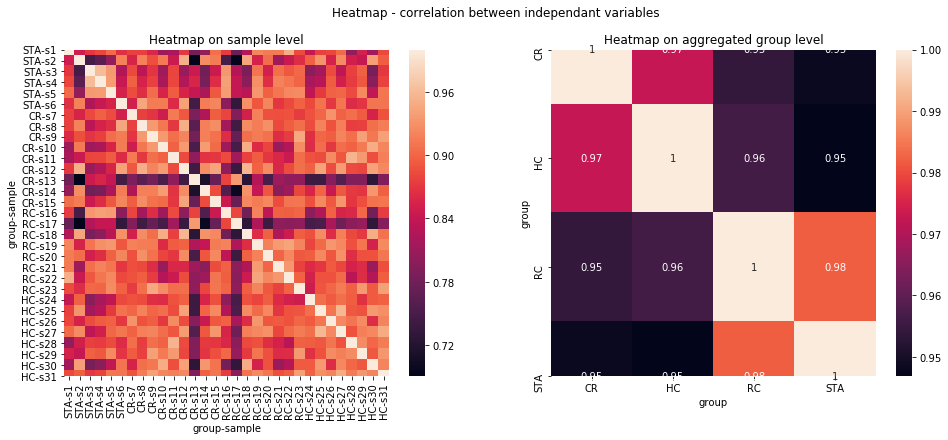

In [3]:
# evaluate correlation between independant variables
# and plot correlation heatmap on sample and aggegated group level
_data = data.drop(columns=['group']).T
_data.columns = pd.MultiIndex.from_arrays(data['group'].reset_index().values[:, ::-1].T,
                                          names=['group', 'sample'])
_agg_data = data.groupby('group').median().T

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 6)
fig.suptitle('Heatmap - correlation between independant variables')
sns.heatmap(_data.corr('spearman'), ax=ax[0]).set_title('Heatmap on sample level')
sns.heatmap(_agg_data.corr('spearman'), annot=True, ax=ax[1]).set_title('Heatmap on aggregated group level')
plt.show()

In the figure above, there are plotted two heatmaps that express the correlation between samples and the correlation between aggregated groups. In the first figure, we can observe some patterns of samples s13 (CR - chronically diseased patients) and s17 (RC - recovered patients) with remaining samples. However, the relationships are vague, and it is difficult to come to any conclusion. Thus, as a next step, we aggregate samples into groups with the hope of getting some information about relationships between these groups.

In the second figure, the correlation values between all groups are quite high (around 0.95-0.98), normally this would mean that the groups are collinear, however we assume that this is not true. Such distortion can be explained by a large number of genes (variables), it is too high to find anything and it distorts the correlation results. In the end, we can conclude that this task was not a good idea.

### Feature Scaling

Before we proceed to apply machine learning and hypothesis testing algorithms, we should review the scale of independent variables, and in case it varies, we should use feature scaling. This is important as many algorithms, such as OLS and ARIMA, require this step to work correctly.

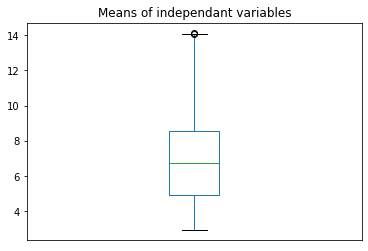

In [4]:
ax = data.mean().round(3).plot(kind='box')
ax.set_xticks([])
plt.title('Means of independant variables')
plt.show()

We can see in the boxplot above the means of independent variables are not equal, they are distributed in range (2; 14), and the median is around 7. Hence we need to perform feature scaling. Since the gene expressions are not bounded, we should utilize a standardization approach.

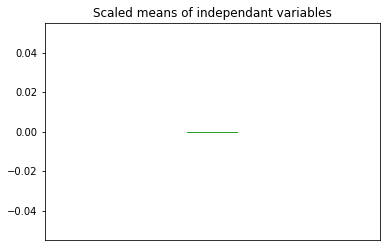

In [5]:
# scale data
scaler = StandardScaler()
columns = [item for item in data.columns if item != 'group']
data[columns] = scaler.fit_transform(data[columns])

ax = data.mean().round(3).plot(kind='box')
ax.set_xticks([])
plt.title('Scaled means of independant variables')
plt.show()

In the boxplot above, we can observe scaled means of independent variables. The means are equal to 0. Thus we can see only one line of a boxplot - the median. And according to the definition of the standardization approach, the standard deviation is equal to 1.

Going forward, we will utilize the scaled dataset in all the following tasks.

### Dimensionality reduction

In this section, we will employ dimensionality reduction algorithms such as PCA, LDA, and t-SNE. This will help us to evaluate patterns between variables and visualize the data in the 2-D scatter plot.

Note: LDA is a generative learning algorithm that makes strong assumptions on the data. The assumptions are the following:
* Independently sampled
* Multivariate normality
* Homoscedasticity

Due to the nature of the data, it is difficult to test these assumptions on the whole dataset. There are many variables, and the hypothesis tests would yield distorted results. Furthermore, unlike the MVN package in R, python libraries do not have a multivariate Shapiro test for testing Multivariate normality. Hence, in this exercise, we would "cheat" and apply LDA without confirming assumptions.

PCA - explained variance (comutative) 
[0.206 0.333 0.414 0.485 0.546 0.584 0.618 0.65  0.681 0.709 0.732 0.752
 0.773 0.793 0.812 0.829 0.845 0.862 0.876 0.89  0.903 0.916 0.928 0.939
 0.951 0.962 0.972 0.982 0.991 1.   ]
LDA - train set loss 0.29


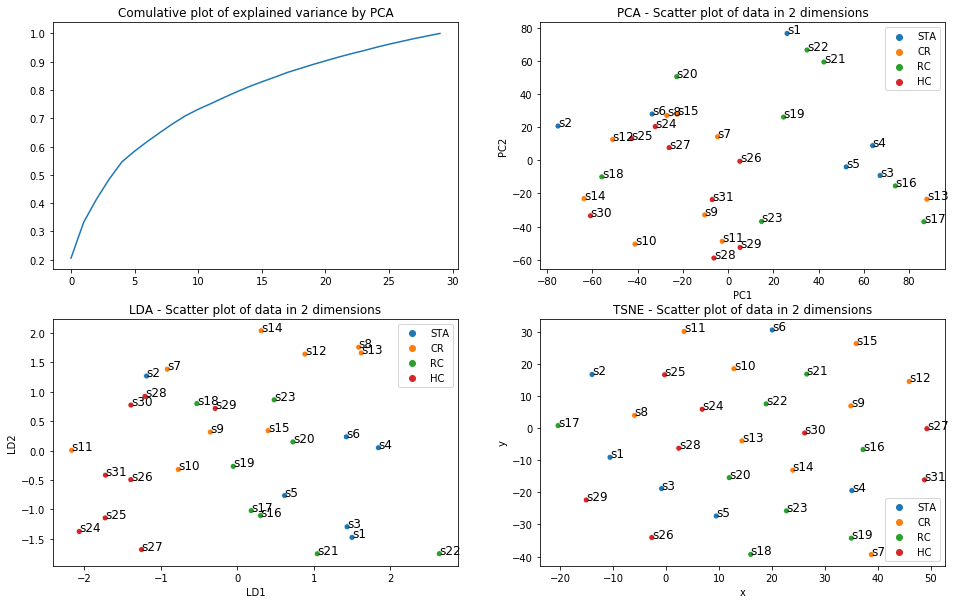

In [7]:
def plot_scatter(X, y, ax, annot, title, x_lable='x', y_lable='y'):
    sns.scatterplot(X[:, 0], X[:, 1], hue=y, ax=ax)
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], annot['sample'].iloc[i], fontsize=12)
    ax.set_xlabel(x_lable)
    ax.set_ylabel(y_lable)
    ax.set_title(title)


# create X and y variables
X = data.drop(columns=['group']).values
y = data['group'].values

# apply PCA on all dimensions for analysing explained variance
pca = PCA(n_components=min(X.shape) - 1)
_X = pca.fit_transform(X)
explained_variance = np.cumsum(pca.explained_variance_ratio_).round(3)
print('PCA - explained variance (comutative) \n{}'.format(explained_variance))

# apply PCA
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)

# apply LDA
lda = LinearDiscriminantAnalysis(n_components=2)
lda_X = lda.fit_transform(X, y)  # Variables are collinear
loss = zero_one_loss(y, lda.predict(X))

print(f'LDA - train set loss {loss:.2f}')

# apply t-SNE
t_sne = TSNE(n_components=2)
t_sne_X = t_sne.fit_transform(X)

# plot the results - comulative and scatter plots
fig, ((ax_1, ax_2), (ax_3, ax_4)) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 10)

ax_1.plot(explained_variance)
ax_1.set_title('Comulative plot of explained variance by PCA')

plot_scatter(pca_X, y, ax_2, annot,
             'PCA - Scatter plot of data in 2 dimensions',
             x_lable='PC1', y_lable='PC2')
plot_scatter(lda_X, y, ax_3, annot,
             'LDA - Scatter plot of data in 2 dimensions',
             x_lable='LD1', y_lable='LD2')
plot_scatter(t_sne_X, y, ax_4, annot,
             'TSNE - Scatter plot of data in 2 dimensions')
plt.show()

In the code above, first, we have applied PCA on all components to see the total explained variance. The maximum number of components is 31, which denotes a minimum number of samples and features. As we can see, the first two principal components (PC1 and PC2) explain 33.3% of the variance.

Then we have plotted a cumulative plot of explained variance by PCA and scatter plot of data in two dimensions (figures 1 and 2). In the scatter plot, data points denote patients, and their health condition is represented by a different color. The groups are clustered together, but they are not entirely separable, and there are several outliers (e.g. s18, s13). There are the following pairs of groups which are mixed together:
* Healthy patients (HC - red) and Chronically diseased patients (CR - orange)
* Stationary patients (STA - blue) and Recovered patients (RC - green)

It is an interesting outcome, as I would expect different clusters: Health patients grouped with Recovered patients and Stationary patients grouped with Chronicall diseased patients.

Next to PCA, there are also scatter plots of the data in two dimensions reduced by LDA and t-SNE algorithms (figures 3 and 4). The LDA is a supervised learning algorithm, and hence it tries to cluster individual groups together. We can observe 4 clusters. However, they are not perfectly separated. Besides dimensionality reduction, LDA is able to perform classification as well, and the 0/1 loss on the train set is 29%.

In general, we can conclude that LDA is not suitable for this data, the assumptions are not met, and the training loss is not ideal (in the following sections, we will see that cross-validated test loss is even higher). But it still gives us a notion that the data are not worthless, and we are able to extract patterns.

Compared to PCA and LDA, the t-SNE spreads the data evenly, but even there, we can find points of the same group clustered together, such as Chronically diseased patients (CR - orange). Though overall, it contains more outliers than previous approaches.

Based on the results of the dimensionality reduction algorithms, we can conclude that there are similarities of genes in each group, and there are genes that influence the patient conditions. Therefore our task in the following sections will be to determine important genes and try to classify patient conditions based on them.

### Clustering

The last experiment in this section is going to be clustering. We will employ Hierarchical clustering and k-Means, plot a dendrogram, and evaluate possible clusters.

Implementation note: In the Scikit-learn library, the hierarchical clustering model is called AgglomerativeClustering.

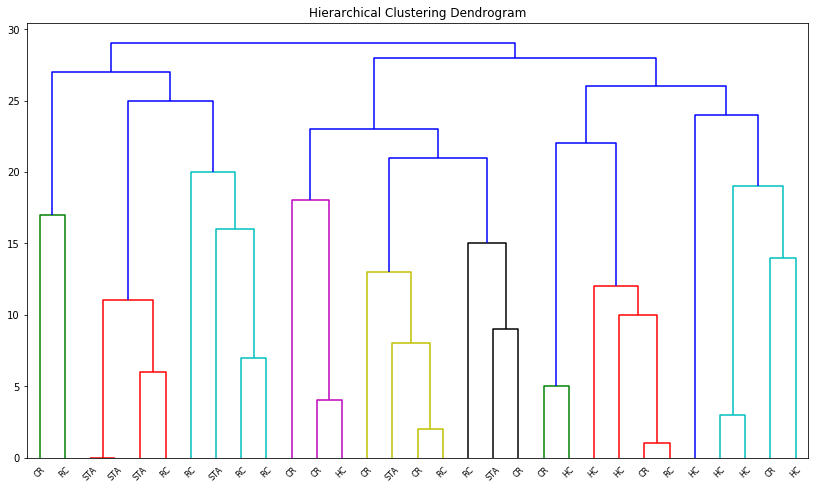

In [8]:
agg_clust = AgglomerativeClustering()
plt.figure(figsize=(14, 8))
agg_clust = agg_clust.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
helper.plot_dendrogram(agg_clust, labels=y)
plt.show()

In the plotted dendrogram, we can find two clusters which contain the following groups as a majority:
* Stationary patients (STA) and Recovered patients (RC) - first ten samples from the left
* Healthy patients (HC) and Chronically diseased patients (CR) - remaining samples from the right

Notice that those are the same groups that we have identified in the previous section - Dimensionality Reduction.

It might be difficult to orientate in the dendrogram, so let us explore the clustering results in the table.

In [9]:
clusters_df = annot.copy()
clusters_df['agglomerative cluster'] = AgglomerativeClustering(2).fit_predict(X)
clusters_df['k_means cluster'] = KMeans(2).fit_predict(X)

clusters_df.sort_values('agglomerative cluster')

,sample,group,agglomerative cluster,k_means cluster
30,s31,HC,0,0
23,s24,HC,0,0
17,s18,RC,0,0
24,s25,HC,0,0
29,s30,HC,0,0
14,s15,CR,0,0
13,s14,CR,0,0
25,s26,HC,0,0
11,s12,CR,0,0
19,s20,RC,0,0


In the table above, there is shown data from annotations.csv with additional columns that represent clusters made by Agglomerative and k-Means clustering. Here it is more clear to see clustered samples into group pairs HC-CR and STA-RC.

However, there are several "misclassified" samples such as s2, s13, s18. Those are the very similar outliers that we have found in scatter plots created by PCA and LDA.

Furthermore, the results of Agglomerative and k-Means clustering are almost the same. Though clusters might be swapped, which depends on initialization, but it is not an important difference.

In the end, it is amazing that we have come to the same conclusion, i.e. that the genes of some patient health conditions are similar to each other by using different approaches (supervised and unsupervised dimensionality reduction and various clustering methods).

## 2. Differential expression

The tasks in the previous section may have distorted results. The main reason is that we were applying algorithms on the full dataset, which contains 10 000 variables (genes). And we can assume that some of the variables are not relevant to us.

The goal of this section will be to determine important independent variables (genes) that influence the dependent variable (patient condition) and evaluate relationships between the groups of the dependent variable. For this, we will employ the ANOVA hypothesis testing method and additional methods that assist ANOVA (Shapiro-Wilk test, Levene test, and Tukey HSD test, aka post-hoc ANOVA).

### ANOVA on sample gene

Let us start with the sample gene "ABHD2". We will test assumptions of ANOVA and then apply ANOVA and post-hoc ANOVA - Tukey HSD. The results will be evaluated by box plots.

The assumptions of ANOVA are the following:
* Independently sampled
* Normality - we will test it with Shapiro-Wilk test
* Homoscedasticity - we will test it with Levene test

Shapiro-Wilk p-value 0.5773571729660034

Levene p-value 0.41042337381937266



[]

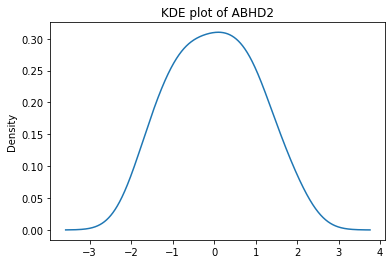

In [10]:
gene_name = 'ABHD2'
group_names, groups = helper.split_into_groups(data, gene_name)

shapiro_res = stats.shapiro(np.concatenate(groups))  # normality test
print(f'Shapiro-Wilk p-value {shapiro_res[1]}\n')

levene_res = stats.levene(*groups, center='mean')  # homodestacity test
print(f'Levene p-value {levene_res.pvalue}\n')

ax = data[gene_name].plot(kind='kde') 
plt.title(f'KDE plot of {gene_name}')
plt.plot()

In the code above, we have applied Shapiro-Wilk and Levene tests to verify assumptions. The p-values are high enough. Thus we won't reject null-hypothesis and conclude that the data are normally distributed, and the populations have equal variances.

Note: For running the Levene test, the mean function was used. It was selected based on the KDE plot of the data of the selected gene. According to the SciPy documentation, mean function is recommended for symmetric, moderate-tailed distribution, which corresponds to the distribution of the selected gene.

Since the assumptions are met, we will proceed to utilize ARIMA and Tukey HSD tests.

ANOVA p-value 0.0011433711883003688

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    CR     HC   0.5393 0.5171 -0.5258 1.6045  False
    CR     RC   1.7661  0.001  0.7009 2.8313   True
    CR    STA   0.7203 0.3404  -0.435 1.8757  False
    HC     RC   1.2268 0.0239  0.1307 2.3228   True
    HC    STA    0.181    0.9 -1.0029 1.3649  False
    RC    STA  -1.0458 0.0977 -2.2297 0.1381  False
---------------------------------------------------


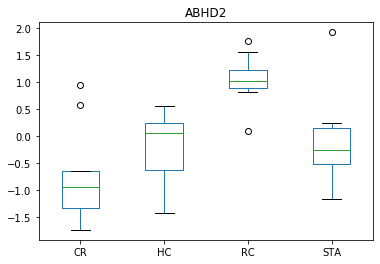

In [11]:
res = stats.f_oneway(*groups)
print(f'ANOVA p-value {res.pvalue}\n')

res = pairwise_tukeyhsd(data[gene_name], data['group'])
print(res)

group_names, groups = helper.split_into_groups(data, gene_name)
data.pivot(columns='group', values=gene_name).plot(kind='box')
plt.title(gene_name)
plt.show()

The ARIMA has returned p-value that is lower than the significance level (0.05), hence we will reject the null hypothesis and state that the groups have different means and that they influence the patient condition.

In the following output made by the Tukey HSD test, we can analyze which pairs of groups are least similar. We see that Chronically diseased patients (CR) and Recovered patients (RC) have the least similar values of the ABHD2 gene, the p-value is 0.001. While Healthy patients (HC) and Stationary patients (STA) have similar values, the p-value is 0.9.

Last, according to the box plot, we can confirm that, indeed, the groups have different means, and we can trust our ARIMA result.

### ANOVA on all genes

After applying ANOVA on one sample, let us iteratively evaluate all genes.

In [12]:
# apply ANOVA for every gene
anova_table = helper.apply_anova(data)
anova_table = anova_table.sort_values('p_value')

anova_table.round(3).head(10)
# note: scaling before appling ANOVA did not change the results

Found 1721 genes that influence health conditions according to ANOVA tests.
Found 1291 genes that influence health conditions according to ANOVA Shapiro-Wilks and Levene tests.


,gene,p_value,shapiro_p_value,levene_p_value
8097,LOC654042,0.0,0.024,0.320
21,C10orf61,0.0,0.020,0.246
7020,RRP12,0.0,0.059,0.982
4624,U1SNRNPBP,0.0,0.170,0.035
8057,CYB5R4,0.0,0.067,0.845
2857,TPI1,0.0,0.082,0.274
1809,PHC2,0.0,0.014,0.359
7311,PALLD,0.0,0.030,0.245
8298,FTHL2,0.0,0.262,0.559
2442,RGN,0.0,0.268,0.224


In [13]:
anova_table.round(3).tail(10)

,gene,p_value,shapiro_p_value,levene_p_value
3164,LILRB1,0.998,0.001,0.239
1239,GGT6,0.999,0.262,0.761
4395,ARID4B,0.999,0.786,0.215
9068,RNF14,0.999,0.399,0.759
8717,SLC12A2,0.999,0.061,0.660
3163,PRDM4,0.999,0.000,0.600
3150,C17orf65,0.999,0.117,0.899
1581,SNORA29,1.000,0.040,0.145
809,TSPO,1.000,0.694,0.038
8006,LOC654350,1.000,0.906,0.290


In the code above, we have applied ANOVA on all genes and printed the table, which contains p-values of ANOVA, Shapiro-Wilk, and Levene tests. This table will help us in the following classification tasks.

In this exercise, we were able to extract 1721 important genes out of 10 000 total genes. Additionally, because we couldn't confirm ANOVA assumptions for several genes, we can apply stronger conditions and extract 1291 important genes.

Now, let us evaluate individual samples of important and unimportant genes.

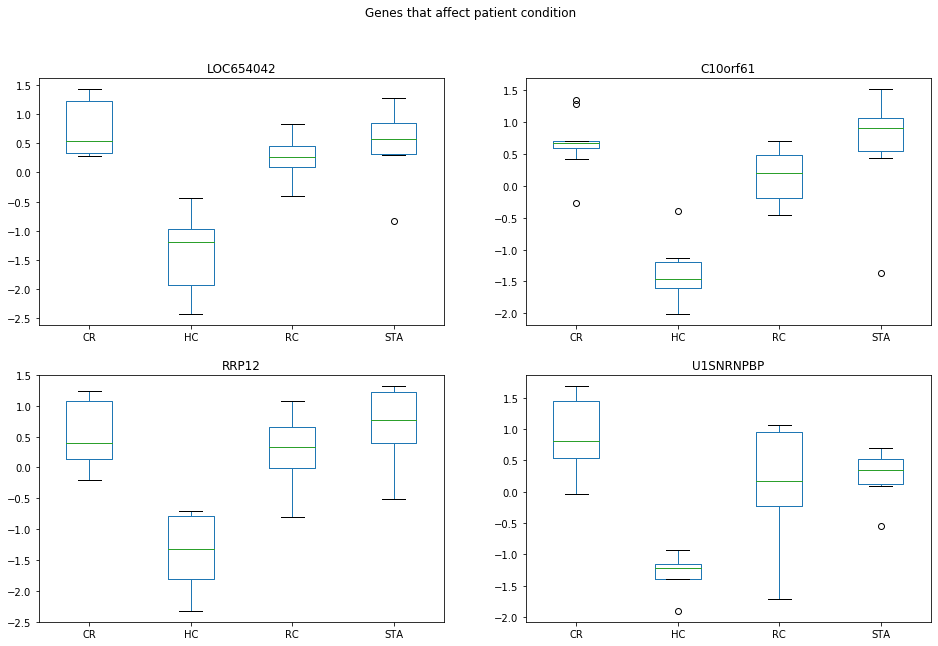

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 10)
data.pivot(columns='group', values='LOC654042').plot(kind='box', ax=ax[0, 0], title='LOC654042')
data.pivot(columns='group', values='C10orf61').plot(kind='box', ax=ax[0, 1], title='C10orf61')
data.pivot(columns='group', values='RRP12').plot(kind='box', ax=ax[1, 0], title='RRP12')
data.pivot(columns='group', values='U1SNRNPBP').plot(kind='box', ax=ax[1, 1], title='U1SNRNPBP')
fig.suptitle('Genes that affect patient condition')
plt.show()

Box plots above represent levels of selected genes that have the highest impact on patient condition according to ARIMA tests. We can clearly see that the levels in the groups are not equal.

The Stationary patients and Chronically diseased patients are somewhat similar, and the values of the genes are high, while levels of healthy patients are low. And Recovered patients are in the middle of those groups. This can be explained by reasoning that Recovered patients are the type of a group of people that were once diseased but now are healthy, i.e. the levels of selected genes have improved (got lower) but did not recover completely.

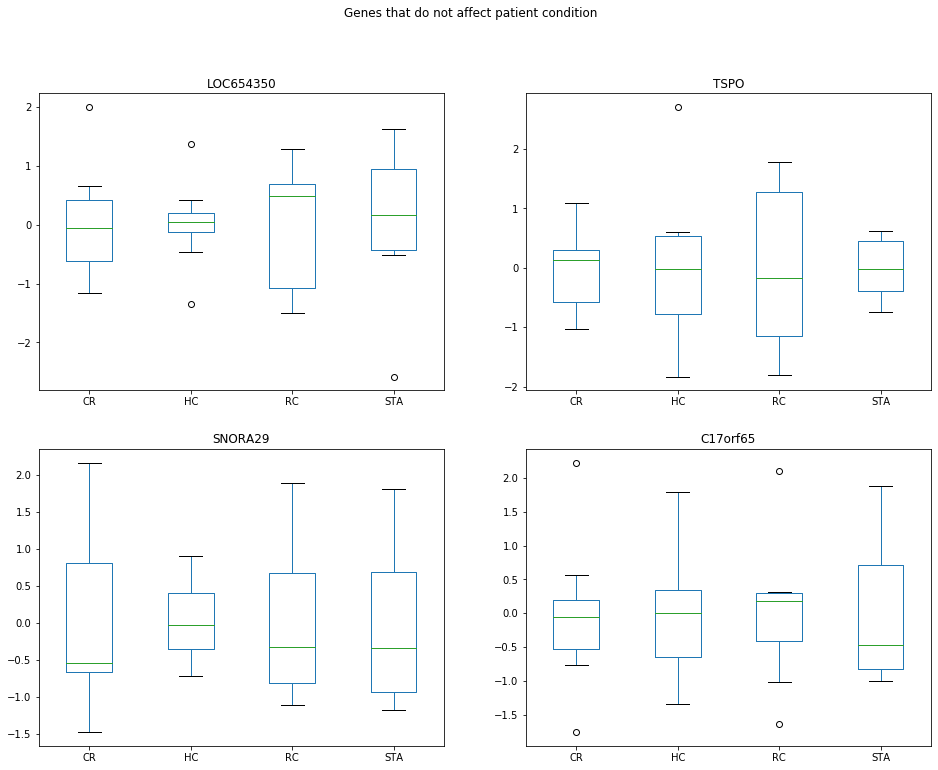

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 12)
data.pivot(columns='group', values='LOC654350').plot(kind='box', ax=ax[0, 0], title='LOC654350')
data.pivot(columns='group', values='TSPO').plot(kind='box', ax=ax[0, 1], title='TSPO')
data.pivot(columns='group', values='SNORA29').plot(kind='box', ax=ax[1, 0], title='SNORA29')
data.pivot(columns='group', values='C17orf65').plot(kind='box', ax=ax[1, 1], title='C17orf65')
fig.suptitle('Genes that do not affect patient condition')
plt.show()

Unlike the genes with high impact on patient condition, the genes presented in the box plots above have zero impact. And we can exclude them from our analysis. This will help us with the curse of dimensionality.

### Tukey HSD - post-hoc ANOVA

After applying ANOVA, we can focus on genes that impact patient condition and evaluate the pairs of groups. For this, we will employ Tukey HSD hypothesis tests. The test will show us which particular pairs of patient conditions are impacted the most by selected 1291 genes.

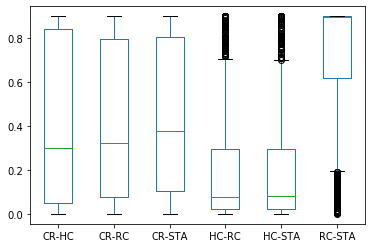

,CR-HC,CR-RC,CR-STA,HC-RC,HC-STA,RC-STA
count,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000
mean,0.409114,0.414212,0.438728,0.215940,0.211636,0.725715
std,0.358728,0.344083,0.336547,0.276837,0.272035,0.253100
min,0.001000,0.001000,0.001000,0.001000,0.001000,0.002604
25%,0.051125,0.078785,0.103905,0.024107,0.023207,0.618449
50%,0.299034,0.323745,0.377984,0.078786,0.082209,0.894639
75%,0.841759,0.797493,0.803401,0.297965,0.294940,0.900000
max,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000


In [17]:
# apply posthoc ANOVA for every gene with rejected null-hypothesis by ANOVA
tukey_table = helper.apply_tukey_hsd(data, anova_table)

tukey_table.plot(kind='box')
plt.show()

tukey_table.describe()

In the box plots above, there are plotted p-values of pairs of patient conditions evaluated by Tukey HSD tests. We can see that the first three pairs do not have particular results. In these categories, few genes have significantly low p-values, but the overall majority (25 percentile) has high p-values, which means that the selected pairs of groups have statistically similar means.

On the other hand, pairs HC-RC and HC-STA have low p-values (almost half of the samples is below the significance level), which means that those conditions are highly impacted by selected genes. I.e. we can easily identify Healthy patients out of Stationary and Recovered patients.

The last boxplot contains p-values of a pair RC-STA, and it indicates that for the majority of selected genes, the values are statistically similar. Again, it is the same result that we have concluded in the first task - Exploratory analysis of the gene expression dataset.

## 3. Phenotype predictive model

In the last task, we will create models that predict the patient condition (phenotype group) based on the gene expression profile. We will evaluate and compare performance with the cross-validation technique - Stratisfied k-Fold. It is an extended k-Fold approach that returns stratified folds, i.e. the folds that are made by preserving the percentage of samples for each class.

We will employ the following algorithms:
* Linear Discriminant Analysis (LDA)
* Logistic Regression
* Random Forest - with 50 trees
* Support Vector Machine (SVM) - with a linear kernel

I have tuned the hyperparameters of selected models, and in the code blocks below, I present the models of each class with the best outcomes.

In [18]:
# apply classification algorithms
print('LDA Classification')
classifier = LinearDiscriminantAnalysis(n_components=2)
classifier = helper.evaluate_classifier(classifier, X, y)

print('Logistic Regression')
classifier = LogisticRegression(multi_class='auto', solver='newton-cg')
classifier = helper.evaluate_classifier(classifier, X, y)

print('Random Forest Classification')
classifier = RandomForestClassifier(n_estimators=50)
classifier = helper.evaluate_classifier(classifier, X, y)

print('SVM Classification')
classifier = SVC(C=10, kernel='linear')
classifier = helper.evaluate_classifier(classifier, X, y)

print('Random Classification - example')
unique_y, unique_y_counts = np.unique(y, return_counts=True)
p = unique_y_counts / unique_y_counts.sum()
k_fold_mean = np.mean([zero_one_loss(y, np.random.choice(unique_y, y.shape[0], 
                                                         replace=True, p=p)) 
                       for _ in range(10)])
print(f'10-Fold mean loss: {k_fold_mean:.3f}')

LDA Classification
	Dataset sizes: (20, 11), loss: 0.545
	Dataset sizes: (20, 11), loss: 0.636
	Dataset sizes: (22, 9), loss: 0.667
k-Fold mean loss: 0.616, std: 0.052
Loss of training on full dataset: 0.29
--------------- 

Logistic Regression
	Dataset sizes: (20, 11), loss: 0.455
	Dataset sizes: (20, 11), loss: 0.545
	Dataset sizes: (22, 9), loss: 0.556
k-Fold mean loss: 0.519, std: 0.045
Loss of training on full dataset: 0.00
--------------- 

Random Forest Classification
	Dataset sizes: (20, 11), loss: 0.364
	Dataset sizes: (20, 11), loss: 0.455
	Dataset sizes: (22, 9), loss: 0.556
k-Fold mean loss: 0.458, std: 0.078
Loss of training on full dataset: 0.00
--------------- 

SVM Classification
	Dataset sizes: (20, 11), loss: 0.455
	Dataset sizes: (20, 11), loss: 0.455
	Dataset sizes: (22, 9), loss: 0.556
k-Fold mean loss: 0.488, std: 0.048
Loss of training on full dataset: 0.00
--------------- 

Random Classification - example
10-Fold mean loss: 0.729


First, we have applied classification algorithms on the full dataset. Based on the results above, the classification did not perform well. All results have cross-validated loss close to 50%. But it is still better than a random classifier that would have mean loss around 70-75% for four classes.

Now, let us explore the results of the reduced dataset.

In [19]:
# reaply classification algorithms
X_reduced = data[anova_table.loc[anova_table['p_value'] < helper.ALPHA, 'gene']].values

classifier = LinearDiscriminantAnalysis(n_components=2)
classifier = helper.evaluate_classifier(classifier, X_reduced, y)

classifier = LogisticRegression(multi_class='auto', solver='newton-cg')
classifier = helper.evaluate_classifier(classifier, X_reduced, y)

classifier = RandomForestClassifier(n_estimators=50)
classifier = helper.evaluate_classifier(classifier, X_reduced, y)

classifier = SVC(C=10, kernel='linear')
classifier = helper.evaluate_classifier(classifier, X_reduced, y)


	Dataset sizes: (20, 11), loss: 0.364
	Dataset sizes: (20, 11), loss: 0.455
	Dataset sizes: (22, 9), loss: 0.556
k-Fold mean loss: 0.458, std: 0.078
Loss of training on full dataset: 0.19
--------------- 

	Dataset sizes: (20, 11), loss: 0.364
	Dataset sizes: (20, 11), loss: 0.091
	Dataset sizes: (22, 9), loss: 0.111
k-Fold mean loss: 0.189, std: 0.124
Loss of training on full dataset: 0.00
--------------- 

	Dataset sizes: (20, 11), loss: 0.273
	Dataset sizes: (20, 11), loss: 0.273
	Dataset sizes: (22, 9), loss: 0.333
k-Fold mean loss: 0.293, std: 0.029
Loss of training on full dataset: 0.00
--------------- 

	Dataset sizes: (20, 11), loss: 0.364
	Dataset sizes: (20, 11), loss: 0.091
	Dataset sizes: (22, 9), loss: 0.111
k-Fold mean loss: 0.189, std: 0.124
Loss of training on full dataset: 0.00
--------------- 



We can see major improvements for the dataset with 1721 variables (genes). All classifiers have improved. Logistic regression and SVM classifiers have the best results with a mean loss of 18.9%.

Random Forest classifier is a little bit behind with the mean loss of 36%. This can be explained by the number of samples. Random Forest is one of the algorithms that require many samples to be precise. And in this case, it is underfitted.

With the lowest score ends up LDA classifier. It is as expected because the data do not satisfy assumptions (see Dimensionality Reduction section). Even the training loss on all samples is not perfect. We can conclude that LDA is not ideal for this particular dataset. As it is a generative learning model, it can predict very well but only on a particular set of problems.

In [20]:
# reaply classification algorithms
X_reduced = data[anova_table.loc[(anova_table['p_value'] < helper.ALPHA) &
                                 (anova_table['shapiro_p_value'] > helper.ALPHA) &
                                 (anova_table['levene_p_value'] > helper.ALPHA),
                                 'gene']].values

classifier = LinearDiscriminantAnalysis(n_components=2)
classifier = helper.evaluate_classifier(classifier, X_reduced, y)

classifier = LogisticRegression(multi_class='auto', solver='newton-cg')
classifier = helper.evaluate_classifier(classifier, X_reduced, y)

classifier = RandomForestClassifier(n_estimators=50)
classifier = helper.evaluate_classifier(classifier, X_reduced, y)

classifier = SVC(C=10, kernel='linear')
classifier = helper.evaluate_classifier(classifier, X_reduced, y)


	Dataset sizes: (20, 11), loss: 0.364
	Dataset sizes: (20, 11), loss: 0.455
	Dataset sizes: (22, 9), loss: 0.556
k-Fold mean loss: 0.458, std: 0.078
Loss of training on full dataset: 0.19
--------------- 

	Dataset sizes: (20, 11), loss: 0.273
	Dataset sizes: (20, 11), loss: 0.091
	Dataset sizes: (22, 9), loss: 0.111
k-Fold mean loss: 0.158, std: 0.081
Loss of training on full dataset: 0.00
--------------- 

	Dataset sizes: (20, 11), loss: 0.455
	Dataset sizes: (20, 11), loss: 0.364
	Dataset sizes: (22, 9), loss: 0.333
k-Fold mean loss: 0.384, std: 0.052
Loss of training on full dataset: 0.00
--------------- 

	Dataset sizes: (20, 11), loss: 0.364
	Dataset sizes: (20, 11), loss: 0.091
	Dataset sizes: (22, 9), loss: 0.111
k-Fold mean loss: 0.189, std: 0.124
Loss of training on full dataset: 0.00
--------------- 



Last, we have applied classifiers on a smaller set of variables - 1291 genes. The results almost did not change. There is one exception a Logistic Regression.

It is an interesting outcome as I have expected SVM to perform better. The main reason is that the SVM can work on datasets with a lot of variables and a few samples. It is able to select support vectors that represent each group and make decisions based on them. But in this example, a simpler approach - Logistic Regression has overcome this.

In the end, we see that ANOVA helped us to determine important genes, and then we were able to improve the performance of the classifiers.

### Random Forest experiment

Random Forest is a model that can relatively simply evaluate feature importance. And I was wondering whether there is a correlation between feature importance evaluated by Random Forest and ARIMA. In the experiment below, we have trained Random Forest on the whole dataset and evaluated the similarity between p-values of ARIMA and the feature importance of Random Forest.

In [21]:
classifier = RandomForestClassifier(n_estimators=50)
classifier = helper.evaluate_classifier(classifier, X, y)

feature_importance = pd.Series(classifier.feature_importances_, name='feature importance')
feature_importance.index = data.drop(columns=['group']).columns
feature_importance = feature_importance.sort_values(ascending=False)

print('Random Forest - Feature Importance analysis')
print(feature_importance.describe(), '\n')

_anova_table = pd.concat((anova_table.set_index('gene'), feature_importance), axis=1)
print('Correlation analysis of feature importance')
print((_anova_table.loc[_anova_table['feature importance'] > 0,
                       ['p_value', 'feature importance']]
                   .rename(columns={'p_value': 'ANOVA p-value', 
                                    'feature importance': 'RF Feature Importance'}))
                   .corr())

	Dataset sizes: (20, 11), loss: 0.636
	Dataset sizes: (20, 11), loss: 0.455
	Dataset sizes: (22, 9), loss: 0.556
k-Fold mean loss: 0.549, std: 0.074
Loss of training on full dataset: 0.00
--------------- 

Random Forest - Feature Importance analysis
count    10000.000000
mean         0.000100
std          0.000728
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.010067
Name: feature importance, dtype: float64 

Correlation analysis of feature importance
                       ANOVA p-value  RF Feature Importance
ANOVA p-value               1.000000              -0.434574
RF Feature Importance      -0.434574               1.000000


There are printed statistics of feature importance in the table above. Most of the variables (features) have importance 0. This is logical due to the ratio of the number of samples and features, as the training algorithm is limited for making decisions.

The important outcome is presented in the Correlation analysis table. There we can see a negative correlation between ANOVA p-values and Random Forest Feature Importance. This again makes sense as we want to have low p-values and high Feature Importance.

Since the Random Forest Classifier has a 50% mean loss, we should interpret the results loosely, and we cannot trust them on a hundred percent. For more precise results, we would need to obtain more samples or apply more detailed analysis.

## 4. Conclusion

In this exercise, we have analyzed gene expression data. We have scaled the dataset and applied dimensionality reduction and clustering algorithms. There we have found out similarities of genes between two pairs of groups
* Stationary patients (STA) and Recovered patients (RC)
* Healthy patients (HC) and Chronically diseased patients (CR)

After we have applied ANOVA hypothesis tests, including supporting tests such as Shapiro-Wilks, Levene, and Tukey HSD tests. This has helped us to identify important genes that affect the health condition of patients.

In the end, we have employed classification models to predict health conditions based on genes. We have evaluated the results with a cross-validation method Stratisfied k-Fold. And we have utilized the results from ANOVA for feature selection, which has drastically improved the performance of the models. Eventually, it has turned out that the simplest approach - Logistic Regression performs the best for this dataset.